# Tutorial 2: Scattering from an impedence sphere

## The problem

**This text still needs updating.**

In this tutorial, we will solve the problem of scattering from the unit sphere $\Omega$ with an incident wave defined by

$$
p_{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}.
$$

where $\mathbf x = (x_0, x_1, x_2)$.

Acoustic waves are governed by the Helmholtz equation:

$$
\Delta p_\text{total} + k^2 p_\text{total} = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $p_\text{total}$ is the total pressure. We can split $p_\text{total}$ into incident and scattered pressures by writing $p_\text{s}+p_\text{inc}$. The scattered pressure ($p_\text{s}$) satisfies the Sommerfeld radiation condition

$$
\frac{\partial p_\text{s}}{\partial r}-\mathrm{i}kp_\text{s}=o(r^{-1})
$$

when $r:=|\mathbf{x}|\rightarrow\infty$.

For our problem, we impose a Neumann boundary condition:

$$
\frac{\partial p_\text{total}}{\partial\mathbf{n}}=0, \quad \text{ on } \Gamma,
$$

where $\Gamma$ is the surface of the sphere $\Omega$, and $\mathbf{n}$ is the normal to the surface $\Gamma$ (pointing outwards).

### Representation formula

It can be shown that the total pressure in our problem can be represented as

$$
p_\text{total} = (\mathcal{K}+\mathrm{i}k\mathcal{V}\mathsf{Y}_n)p_\text{total} + p_\text{inc}
$$

where $\mathcal{V}$ is the single layer potential operator; $\mathcal{K}$ is the double layer potential operator; and $\mathsf{Y}_n$ is...

### Boundary integral equation

It can be shown that the total and incident pressures satisfy the following equation on the surface $\Gamma$:

$$
(\mathsf{K}-\tfrac{1}{2}\mathsf{Id}+\mathrm{i}k\mathsf{V}\mathsf{Y}_n)p_\text{total} = -p_\text{inc},
$$

where $\mathsf{V}$ is the single layer boundary operator; $\mathsf{K}$ is the double layer boundary operator; and $\mathsf{Id}$ is the identity operator.

### Solving with Bempp

We start by importing Bempp and other libraries we will use.

In [1]:
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.assembly.discrete_boundary_operator import DiagonalOperator
import numpy as np
import scipy.sparse
from matplotlib import pyplot as plt

We set the wavenumber we will use (15), create the discretised sphere, and define a space of piecewise constant functions.

In [2]:
k = 15.

grid = bempp.api.shapes.regular_sphere(4)

space = bempp.api.function_space(grid, "DP", 0)

We define the identity ($\mathsf{Id}$), single layer ($\mathsf{V}$) and double layer ($\mathsf{K}$) boundary operators. Each operator is given three spaces as inputs: the domain, range, and dual spaces (in that order).

In this example, all three spaces are the same. In more complex examples, this will not alwasy be the best choice and spaces must be chosen carefully. The single and double layer operators also take the wavenumber as an input.

In [3]:
identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)
single_layer = helmholtz.single_layer(space, space, space, k)

We define the operator $\mathsf{Y}_n$ to be 0 on the face where $x_1=0$ and 1 elsewhere. We use Bempp's `DiagonalOperator` to create an operator that effectively multiplies by this function.

In [4]:
@bempp.api.real_callable
def y_n_callable(x, n, domain_index, result):
    if x[1] < 0:
        result[0] = 0
    else:
        result[0] = -0.8

        
y_n_fun = bempp.api.GridFunction(space, fun=y_n_callable)
y_n = DiagonalOperator(y_n_fun.coefficients)

/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


We define the incident wave, $p_{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}$, and create a Bempp `GridFunction` to represent its value on the boundary in the discrete space.

In [5]:
@bempp.api.complex_callable
def p_inc_callable(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])


p_inc = bempp.api.GridFunction(space, fun=p_inc_callable)

As our formulation contains $\mathsf{Y}_n$ which is defined directly by its weak form, we must get the weak form of the other BEM operators before combining them.

We create the right-hand (`rhs`) and left-hand (`lhs`) sides of our boundary integral equation,

$$
(\mathsf{K}-\tfrac{1}{2}\mathsf{Id}+\mathrm{i}k\mathsf{V}\mathsf{Y}_n)p_\text{total} = -p_\text{inc}.
$$

We them pass these into Scipy's GMRES directly: this is because we have already taken the weak forms so are no longer passing in Bempp operators. We then convert the result back into a Bempp `GridFunction`. We also create a `GridFunction` representing $\mathsf{Y}_np_\text{total}$ as this appears in our representation formula.

In [6]:
rhs = (double_layer - 0.5 * identity).weak_form() + 1j * k * single_layer.weak_form() * y_n
lhs = -p_inc.coefficients

p_total_coefficients, info = scipy.sparse.linalg.gmres(rhs, lhs, tol=1E-5)

p_total = bempp.api.GridFunction(space, coefficients=p_total_coefficients)
y_n_times_p_total = bempp.api.GridFunction(space, coefficients=y_n * p_total_coefficients)

We now plot a some 2D slices through the solution. First, we use Numpy to create a grid of points to evaluate the solution at.

In [7]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

Finally, we plot a slice through the solution.

The magic command `%mathplotlib inline` allows matplotlib to display plots inside Jupyter notebooks. This command should be removed if running this outside a notebook.

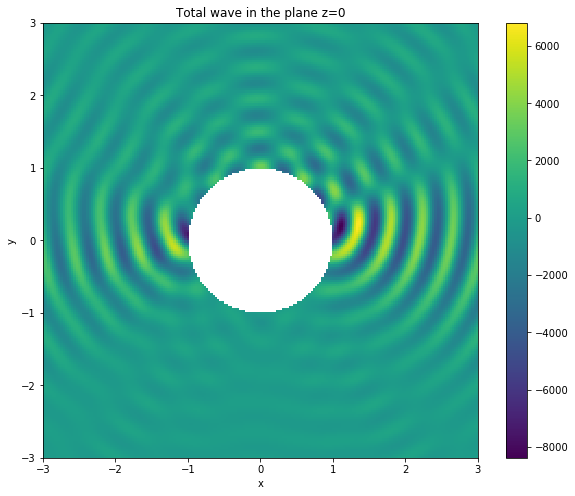

In [8]:
x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

single_pot = helmholtz_potential.single_layer(space, points[:, idx], k)
double_pot = helmholtz_potential.double_layer(space, points[:, idx], k)

u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan
u_evaluated[idx] = np.real(np.exp(1j * k * points[0, idx])
                           + double_pot.evaluate(p_total)
                           + 1j * k * single_pot.evaluate(y_n_times_p_total)).flat
u_evaluated = u_evaluated.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T[::-1]), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()